<a href="https://colab.research.google.com/github/MiguelRochaBE/MotorImagery-BCI/blob/master/MI_BCI_DatasetAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Conexão ao Google Colab**

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


## **Extrair base de dados do ficheiro zip**

Link: https://physionet.org/content/eegmmidb/1.0.0/

In [ ]:
!unzip -u "/content/drive/MyDrive/B(i)onitos/files.zip" -d "/content/drive/MyDrive"

unzip:  cannot find or open /content/drive/folders/1-AQ0e7zyb4ns3ZV7YGILoz95nTGsGBc8/files.zip, /content/drive/folders/1-AQ0e7zyb4ns3ZV7YGILoz95nTGsGBc8/files.zip.zip or /content/drive/folders/1-AQ0e7zyb4ns3ZV7YGILoz95nTGsGBc8/files.zip.ZIP.


## **Listar todos os ficheiros da base de dados**

In [4]:
import os

def run_fast_scandir(dir, ext):    # dir: str, ext: list
    subfolders, datafiles = [], []

    for f in os.scandir(dir):
        if f.is_dir():
            subfolders.append(f.path)
        if f.is_file():
            if os.path.splitext(f.name)[1].lower() in ext:
                datafiles.append(f.path)

    for dir in list(subfolders):
        sf, f = run_fast_scandir(dir, ext)
        subfolders.extend(sf)
        datafiles.extend(f)
    return subfolders, datafiles


subfolders, datafiles = run_fast_scandir('/content/drive/MyDrive/files', [".edf"])
#subfolders, eventfiles = run_fast_scandir('/content/drive/MyDrive/files', [".event"])

subfolders.sort()
datafiles.sort()
print(subfolders[:3])
print(datafiles[:3])


['/content/drive/MyDrive/files/S001', '/content/drive/MyDrive/files/S002', '/content/drive/MyDrive/files/S003']
['/content/drive/MyDrive/files/S001/S001R01.edf', '/content/drive/MyDrive/files/S001/S001R02.edf', '/content/drive/MyDrive/files/S001/S001R03.edf']


## **Biblioteca MNE: https://mne.tools/stable/index.html**


In [1]:
!pip install mne
import mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 27.3 MB/s eta 0:00:00


## **Ler dados e separar/agrupar os blocos de EEG consoante o tipo/classe de movimento**

Files to read:  ['/content/drive/MyDrive/files/S002/S002R01.edf', '/content/drive/MyDrive/files/S002/S002R02.edf', '/content/drive/MyDrive/files/S002/S002R03.edf', '/content/drive/MyDrive/files/S002/S002R04.edf', '/content/drive/MyDrive/files/S002/S002R05.edf', '/content/drive/MyDrive/files/S002/S002R06.edf', '/content/drive/MyDrive/files/S002/S002R07.edf', '/content/drive/MyDrive/files/S002/S002R08.edf', '/content/drive/MyDrive/files/S002/S002R09.edf', '/content/drive/MyDrive/files/S002/S002R10.edf', '/content/drive/MyDrive/files/S002/S002R11.edf', '/content/drive/MyDrive/files/S002/S002R12.edf', '/content/drive/MyDrive/files/S002/S002R13.edf', '/content/drive/MyDrive/files/S002/S002R14.edf']
Extracting EDF parameters from /content/drive/MyDrive/files/S002/S002R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...

Trial:  3
Used Annotations descriptions: ['T0', 'T1', 'T2']


Not setting met

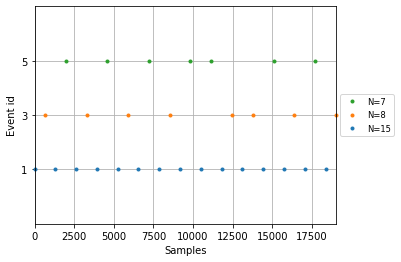

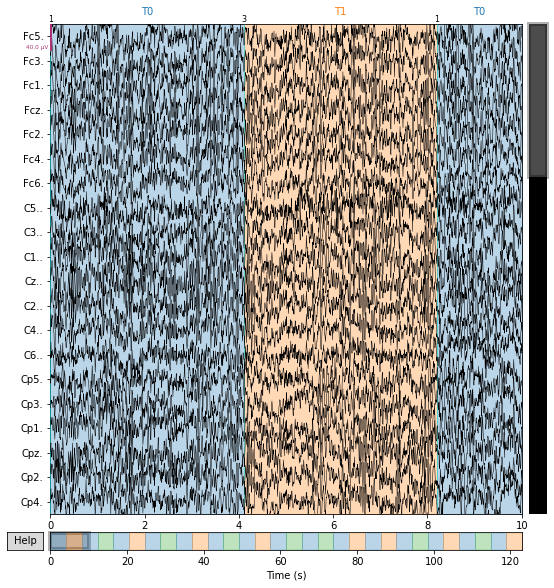

Not setting metadata
348 matching events found
No baseline correction applied


<ipython-input-14-80e5d9faefdc>:67: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(all_trials, add_offset = True, on_mismatch = 'raise')


In [14]:
def load_subject_data(subject, datafiles):

  '''
  Descrição dos eventos:

  Each annotation includes one of three codes (T0, T1, or T2):

    - T0 corresponds to rest
    - T1 corresponds to onset of motion (real or imagined) of the left fist (in runs 3, 4, 7, 8, 11, and 12)
                                                                    both fists (in runs 5, 6, 9, 10, 13, and 14)
    - T2 corresponds to onset of motion (real or imagined) of the right fist (in runs 3, 4, 7, 8, 11, and 12)
                                                                    both feet (in runs 5, 6, 9, 10, 13, and 14)
  '''

  trials=[] # Pré-alocação do array na memória
  for trial in datafiles: 
    if subject in trial: 
      trials.append(trial)
  
  print("Files to read: ", trials)
  
  all_trials = []
  for count, trial  in enumerate(trials):
    if count > 1: # Avança os dois primeiros trials correspondentes ao rest
      data = mne.io.read_raw_edf(trial, preload = True) # Dados EEG para um trial específico. 'Preload=True' serve para colocar o ficheiro na memória e não apenas referenciá-lo no diretório

      ch_names = data.ch_names # Elétrodos
      fs =  data.info.get('sfreq') # Frequência de amostragem
      annotations = data.annotations # Variável que contém os dados no tempo relativos aos blocos de movimentos executados
      
      trial_type1 = [3, 4, 7, 8, 11, 12]
      trial_type2 = [5, 6, 9, 10, 13, 14]

      # Atribuição das labels corretas aos eventos de cada trial

      trial_number = int(trial.split('.')[0][-2:]) # De 1 a 14; [0] corresponde à primeira parte da string original;
      print("\nTrial: ",trial_number)
      if trial_number in trial_type1:
        event_ids = {'T0': 1, 'T1': 2, 'T2': 4} # Dicionário com os ids dos eventos de acordo com a descrição a laranja ^^
        epoch_event_ids = {"rest/block": 1, "left_fist/block": 2, "both_fists/block": 4}
      elif trial_number in trial_type2:
        event_ids = {'T0': 1, 'T1': 3, 'T2': 5}
        epoch_event_ids = {"rest/block": 1, "right_fist/block": 3,"both_feet/block": 5}
      else:
        event_ids = {'T0': 1}

      events = mne.events_from_annotations(data, event_id = event_ids) # Variável eventos: Retorna 3 colunas [Indice da amostra onde começa o bloco, Trigger, Tipo de movimento (label)]
      print("\n")
      
      # Agrupamento dos blocos do mesmo id

      epochs = mne.Epochs(data, events[0], event_id = epoch_event_ids, baseline = None, preload = True)
      print("Informação dos blocos: ", epochs.info)
      #epochs["right_fist"].plot_image(picks=[8])

      if count == len(trials)-1:
        print("\nInfo dos dados: ", data.info)
        print("\nElétrodos: ", ch_names)
        print("\nAnotações: ", annotations.description)
        print("\nEventos: ", events)
        print("\n")
        figure = mne.viz.plot_events(events[0]) # Gráfico dos eventos
        data.plot(events=events[0]) # Plot dos dados com a speraração dos eventos

      all_trials.append(epochs)

  subject_epochs = mne.concatenate_epochs(all_trials, add_offset = True, on_mismatch = 'raise')
  
  return subject_epochs

subject_epochs = load_subject_data(subfolders[1],datafiles)


In [17]:
dir(subject_epochs)

['__class__',
 '__contains__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_annotations',
 '_bad_dropped',
 '_channel_type_idx',
 '_check_consistency',
 '_check_metadata',
 '_compute_aggregate',
 '_current',
 '_data',
 '_decim',
 '_decim_slice',
 '_detrend_offset_decim',
 '_detrend_picks',
 '_do_baseline',
 '_do_delayed_proj',
 '_evoked_from_epoch_data',
 '_filename',
 '_get_channel_positions',
 '_get_data',
 '_get_epoch_from_raw',
 '_getitem',
 '_handle_tmin_tmax',
 '_is_good_epoch',
 '_item_to_select',
 '_keys_to_idx',
 '_metadata',
 '_name',
 '_offset',
 '_pick_drop_channels',
 '_pick_projs',
 '_project_e

In [22]:
dt = subject_epochs.to_data_frame()
print(dt)

          time         condition  epoch  Fc5.  Fc3.  Fc1.  Fcz.  Fc2.  Fc4.  \
0     -0.20000   left_fist/block      1  -2.0   9.0   5.0   4.0   4.0  11.0   
1     -0.19375   left_fist/block      1  10.0   8.0  -6.0 -12.0 -10.0  -5.0   
2     -0.18750   left_fist/block      1   7.0   8.0 -12.0 -19.0 -17.0 -16.0   
3     -0.18125   left_fist/block      1   3.0   7.0  -6.0  -7.0 -12.0 -15.0   
4     -0.17500   left_fist/block      1 -31.0 -21.0 -26.0 -16.0 -18.0 -18.0   
...        ...               ...    ...   ...   ...   ...   ...   ...   ...   
39319  0.47500  right_fist/block    359 -44.0 -43.0 -31.0 -32.0 -22.0 -30.0   
39320  0.48125  right_fist/block    359 -23.0 -21.0  -7.0  -7.0  -2.0 -15.0   
39321  0.48750  right_fist/block    359 -22.0 -17.0  -2.0  -3.0   1.0 -11.0   
39322  0.49375  right_fist/block    359  -3.0  -3.0   9.0   7.0  17.0   7.0   
39323  0.50000  right_fist/block    359 -15.0 -21.0  -6.0  -3.0   5.0  -1.0   

       Fc6.  ...  P8..  Po7.  Po3.  Poz.  Po4.  Po8